In [1]:
from io import StringIO

import numpy as np
import pandas as pd
import requests
from scipy.stats import norm, expon, chi2, uniform
import matplotlib.pyplot as plt
%matplotlib inline

# Foundations for statistical inference - Confidence intervals

Based on OpenIntro Labs for Python: https://github.com/vaksakalli/stats_tutorials, https://www.openintro.org/book/os/

## Sampling from King County

Let's first load the data that we already know: the official public records of all 21613 home sales from May 2014 through May 2015 in the King County area, Washington State (https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html). 

In [7]:
house_df = pd.read_csv('../Notebook1/kc_house_data.csv')

This is what we would call a "population", that is *all* home sales in that period in that area. It allows to answer questions like, "How big is the typical house sold in King County in 2014?" and "How much variation is there in sizes of houses sold in that area in that period?".

Gathering information on an entire population is often extremely costly or impossible, and so having access to it is rarely the case in real life. Because of this, we often take a *sample* of the population and use that to understand the properties of the population.

If you have access to only a sample of the population, answering the above questions becomes more complicated. What is your best guess for the typical size if you only know the sizes of several dozen houses? Guessing from samples to conclude about the population is called *inference*.

### Exercise 1
a) take a sample of N=100 random house prices, and compare histograms, means, and standard deviations of the sample and the population. Repeat it several times and observe what changes.

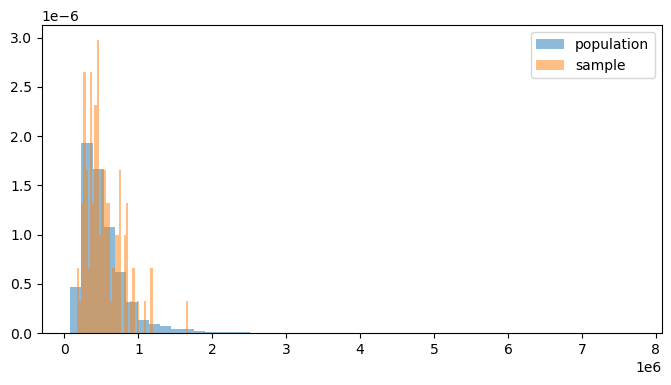

Population Mean: 540088.1417665294
Population Std Dev: 367127.1964826997
Sample Mean: 534043.05
Sample Std Dev: 253949.678352426


In [17]:
prices=house_df["price"]
sample_prices = prices.sample(n=100, random_state=np.random.randint(0, 10000)) #random house prices 

#calculating basic values
normal_mean = prices.mean()
normal_std = prices.std()
sample_mean = sample_prices.mean()
sample_std = sample_prices.std()

plt.figure(figsize=(8,4))
plt.hist(prices, bins=50, density=True, alpha=0.5, label='population')
plt.hist(sample_prices, bins=50, density=True, alpha=0.5, label='sample')

plt.legend()
plt.show()

print("Population Mean:", normal_mean)
print("Population Std Dev:", normal_std)
print("Sample Mean:", sample_mean)
print("Sample Std Dev:", sample_std)


Not surprisingly, every time we take another random sample, we get a different sample mean. It's useful to get a sense of just how much variability we should expect when estimating the population mean this way. The distribution of sample means, called the *sampling distribution*, can help us understand this variability. Here, because we have access to the population, we can build up the sampling distribution for the sample mean by repeating the above steps many times.

b) generate 1000 samples and compute the sample mean of each. Plot the sampling distribution against the population mean.

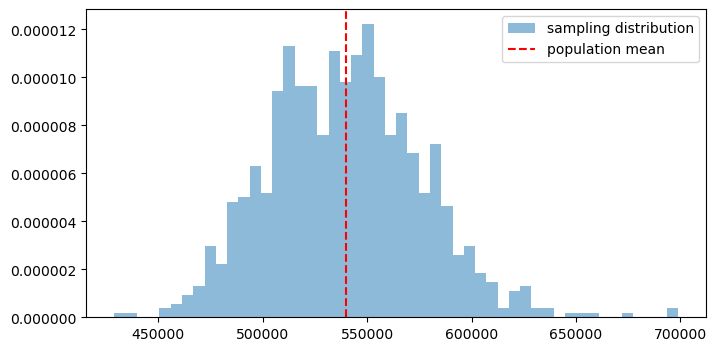

In [25]:
num_of_samples = 1000
sample_size = 100
sample_means = []

#generating samples and adding their mean values to the result list 
for _ in range(num_of_samples):
    sample = prices.sample(n=sample_size, random_state=np.random.randint(0, 10000))
    sample_means.append(sample.mean())

plt.figure(figsize=(8,4))
plt.hist(sample_means, bins=50, density=True, alpha=0.5, label='sampling distribution')
plt.axvline(normal_mean, color='r', linestyle='dashed', label='population mean ')

plt.legend()
plt.ticklabel_format(axis="y", style="plain") #deleting exponential notation
plt.show()



Because the sample mean is an unbiased estimator, the sampling distribution is centered at the true average living area of the the population, and the spread of the distribution indicates how much variability is induced by sampling only 100 home sales.
The standard deviation of sampling distribution is called the *standard error (SE)* of a statistic. If the parameter or the statistic is the mean, it is called the *standard error of the mean (SEM)*.

To get a sense of the effect that sample size has on our distribution, let's build up more sampling distributions:

c) build sampling distributions for $N=2, 4, 8, ..., 4096$, compute their standard deviations, plot them on logarithmic-logarithimics scale, and compare them to $1/\sqrt{N}$.

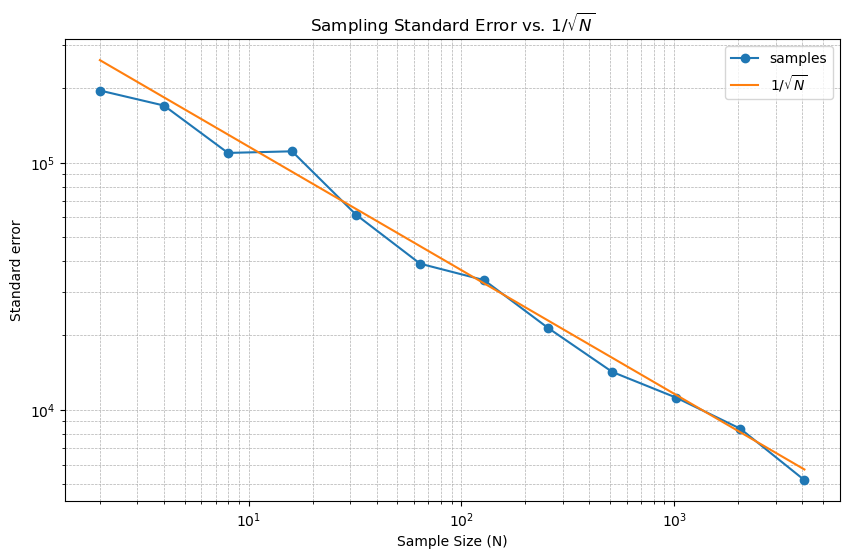

In [40]:
sample_std = []
theoretical_std = []

max_size = 4096
samples_size = [2**i for i in range(1, 13)] #12 is 2**12

for i in samples_size:
    sample_means = []
    num_samples = 100 #liczba prób dla każdego rozmiaru próbki 
    
    for _ in range(num_samples):
        sample = prices.sample(n=i, random_state=np.random.randint(0, 10000))
        sample_means.append(sample.mean())
    
    sample_std.append(np.std(sample_means)) #computing standard error for every sample_size
    theoretical_std.append(normal_std/np.sqrt(i))
    
plt.figure(figsize=(10, 6))
plt.loglog(samples_size, sample_std, label='samples', marker='o')
plt.loglog(samples_size, theoretical_std, label='$1/\sqrt{N}$', linestyle='-')
plt.xlabel('Sample Size (N)')
plt.ylabel('Standard error')
plt.title('Sampling Standard Error vs. $1/\\sqrt{N}$')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show() 


In this way, **samples_size** tells us how large each sample will be, while **num_samples** tells us how many such samples we will generate in order to calculate the standard deviation.

As expected (https://en.wikipedia.org/wiki/Standard_error#Standard_error_of_the_mean) SEM behaves like $\propto 1/\sqrt{N}$, which means that the larger sample you have, the more precise estimate of the population mean you can derive.

## Confidence intervals
One of the most common ways to describe the typical or central value of a distribution is to use *point estimate*, i.e., a single plausible value for a parameter, e.g., the sample mean (usually denoted as $\bar{x}$). However, usually there is some error in the estimate. In addition to supplying a point estimate of a parameter, a next logical step would be to provide a plausible range of values, in our case a *confidence interval*.

After setting the *confidence level* (the probability that the parameter lies in a given interval), usually 95%, we can compute the confidence interval (CI) for the sample mean.
If the sampling distribution is normally distributed one can do it by adding and subtracting 1.96 standard errors to the point estimate: $\bar{x}\pm 1.96\times SE$.

In [42]:
sample_prices = prices.sample(100)
sample_mean=sample_prices.mean()
se = np.std(sample_prices)/np.sqrt(100)
lower = sample_mean - (1.96 * se)
upper = sample_mean + (1.96 * se)
print(lower, upper)

474619.18928424537 593967.9107157547


This is an important inference that we've just made: even though we don't know what the full population looks like, we're 95% confident that the true average price of houses sold in Kings County lies between the values `lower` and `upper`. There are a few conditions that must be met for this interval to be valid.

## Exercise 2
a) generate a normal distribution with the mean and standard deviation equal to the ones from the price distribution.
Compute the probability (use *cumulative distribution function*, `cdf`) of the random variable lying inside the interval $[\mu-1.96\times \sigma,\mu+1.96\times \sigma]$ (where $\mu$ and $\sigma$ are population parameters).
Plot it.
Compute a 99% confidence interval (use `interval`).

Probability that random value lies within lower and upper case: 0.950004209703559


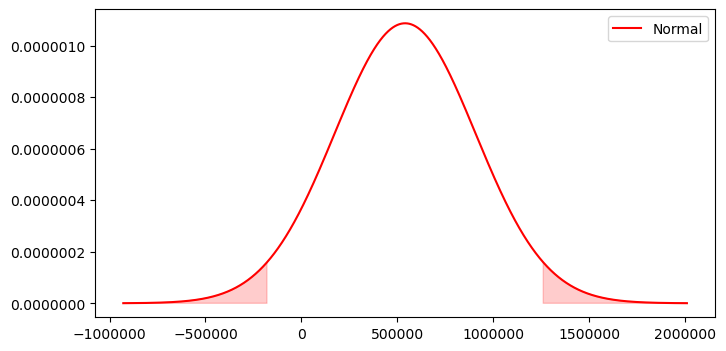

99% Confidence Interval: (np.float64(-405568.8490633633), np.float64(1485745.132596422))


In [59]:
normal_mean = prices.mean()
normal_std = prices.std()

rv_norm = norm(loc=normal_mean, scale=normal_std)

lower = normal_mean - (1.96 * normal_std)
upper = normal_mean + (1.96 * normal_std)

probability = rv_norm.cdf(upper) - rv_norm.cdf(lower)
print("Probability that random value lies within lower and upper case:", probability)

x= np.linspace(normal_mean - 4*normal_std, normal_mean + 4*normal_std, 10000)
y = rv_norm.pdf(x)

plt.figure(figsize=(8, 4))
plt.plot(x, y, color='red', label='Normal')
plt.fill_between(x, y, where=(x <= lower) | (x >= upper), alpha=0.2, color='red')

plt.legend()
plt.ticklabel_format(axis="y", style="plain")
plt.ticklabel_format(axis="x", style="plain")
plt.show()


confidence_interval = rv_norm.interval(0.99)
print(f"99% Confidence Interval: {confidence_interval}")



b) generate a sample of $N=10 000$ normally distributed random numbers with the mean and standard deviation equal to the ones from the price distribution.
Compute the mean and standard deviation of such a sample.
Compute what percentage of numbers lie outside of the interval: $[\bar{x}-1.96\times SD,\bar{x}+1.96\times SD]$.

In [67]:
# your code
N = 10000
sample = prices.sample(n=N, random_state=np.random.randint(0, 10000))

sample_mean = sample.mean()
sample_std = sample.std()

lower = sample_mean - 1.96 * sample_std
upper = sample_mean + 1.96 * sample_std

#Compute the percentage of numbers outside of the interval
outside_percentage = 100 * np.sum((sample < lower) | (sample > upper)) / N
print(f"Percentage of numbers outside the interval {outside_percentage} %")


Percentage of numbers outside the interval 3.98 %


c) take $N=1000$ samples of size $n=50$ from the data prices.
For each sample compute mean, SEM and a confidence interval. Check if the *true population mean* lies within or without the CI.
What is the percentage of instances that the true mean what not in the CI?

In [74]:
# your code
N = 1000
n = 50
ci_percentage_outside = 0  #to calculate the percentage of times true mean is outside the CI
outside_ci_count = 0 #to store results

for _ in range(N):
    sample = prices.sample(n=n, random_state=np.random.randint(0, 10000))
    
    sample_mean = sample.mean()
    sample_std = sample.std()
    
    sem = sample_std / np.sqrt(n) #sem is a Standard Error of the Mean - mówi o tym jak dokładnie mozemy oszacować cała srednia całej populacji 
    '''
    SD -  to odchylenie standardowe - jak rozproszone są dane w próbce
    SEM jest mniejszy od SD, ponieważ uwzględnia tylko zmienność średniej próbki, a nie całą zmienność danych.
    '''
    
    lower = sample_mean - 1.96 * sem
    upper = sample_mean + 1.96 * sem
    
    #check if true population mean is inside the CI
    if not (lower <= normal_mean <= upper):
        outside_ci_count += 1

#calculating the persentage 
outside_percentage = (outside_ci_count / N) * 100

# Print the result
print(f"Percentage of times the true mean was outside the CI: {outside_percentage:.2f}%")
    
    


Percentage of times the true mean was outside the CI: 8.60%


The obtained percentage of 8.6%, where the true population mean lies outside the interval, is fairly close to the expected 5%. This slight difference can be attributed to the inherent randomness in the sampling process. So this indicates that the confidence intervals are functioning as expected.

Now, look again at the result Ex.2b and the meaning of confidence level.
A 95% confidence level does not state that for a given realized interval there is a 95% probability that the population parameter lies within the interval (i.e., a 95% probability that the interval covers the population parameter).
The confidence level states that 95% of randomly chosen samples produce confidence interval that cover the population parameter, and 5% of samples have CIs that do not cover the true value.

For reference, see: https://en.wikipedia.org/wiki/Confidence_interval#Meaning_and_interpretation

# Inference for numerical data
## North Carolina births
In 2004, the state of North Carolina released a large data set containing information on births recorded in this state. This data set is useful to researchers studying the relation between habits and practices of expectant mothers and the birth of their children. We will work with a random sample of observations from this data set.

Load the `nc` data set into our notebook.

In [87]:
import pandas as pd
import requests
from io import StringIO
#https://www.openintro.org/stat/data/nc.csv - original url

nc = pd.read_csv('nc.csv') #have to download this file because I've got some problems with the url
nc.head()

,fage,mage,mature,weeks,premie,visits,marital,gained,weight,lowbirthweight,gender,habit,whitemom
0,NaN,13,younger mom,39.0,full term,10.0,married,38.0,7.63,not low,male,nonsmoker,not white
1,NaN,14,younger mom,42.0,full term,15.0,married,20.0,7.88,not low,male,nonsmoker,not white
2,19.0,15,younger mom,37.0,full term,11.0,married,38.0,6.63,not low,female,nonsmoker,white
3,21.0,15,younger mom,41.0,full term,6.0,married,34.0,8.00,not low,male,nonsmoker,white
4,NaN,15,younger mom,39.0,full term,9.0,married,27.0,6.38,not low,female,nonsmoker,not white


We have observations on 13 different variables, some categorical and some numerical. The meaning of each variable is as follows.

| variable         | description |
| ---------------- | ------------|
| `fage`           | father's age in years. |
| `mage`           | mother's age in years. |
| `mature`         | maturity status of mother. |
| `weeks`          | length of pregnancy in weeks. |
| `premie`         | whether the birth was classified as premature (premie) or full-term. |
| `visits`         | number of hospital visits during pregnancy. |
| `marital`        | whether mother is `married` or `not married` at birth. |
| `gained`         | weight gained by mother during pregnancy in pounds. |
| `weight`         | weight of the baby at birth in pounds. |
| `lowbirthweight` | whether baby was classified as low birthweight (`low`) or not (`not low`). |
| `gender`         | gender of the baby, `female` or `male`. |
| `habit`          | status of the mother as a `nonsmoker` or a `smoker`. |
| `whitemom`       | whether mom is `white` or `not white`. |

## Exercise 3
Consider the possible relationship between a mother's smoking habit and the weight of her baby.

a) plot histograms of baby weights for smoker and non-smoker mothers. Compute means of these two groups (use `groupby`).

In [90]:
smoker = nc[nc['habit'] == "smoker"]
non_smoker = nc[nc['habit'] == "nonsmoker"]

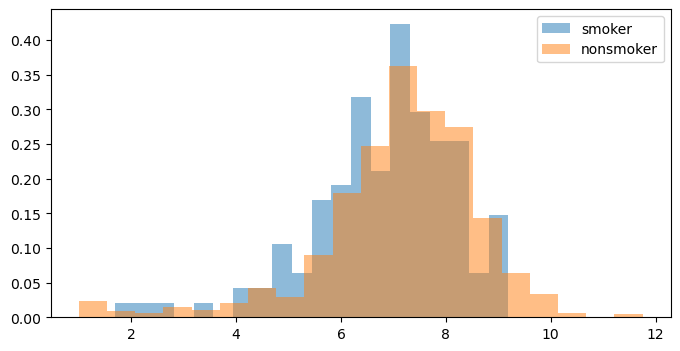

Smoker : 6.829
Non-smoker : 7.144


In [96]:
smoker_mean = smoker['weight'].mean()
non_smoker_mean = non_smoker['weight'].mean()

plt.figure(figsize=(8, 4))
plt.hist(smoker['weight'], bins=20, density=True, alpha=0.5, label='smoker')
plt.hist(non_smoker['weight'], bins=20, density=True, alpha=0.5, label='nonsmoker')
plt.legend()
plt.show()

print(f"Smoker : {smoker_mean:.3f}")
print(f"Non-smoker : {non_smoker_mean:.3f}")

We will now conduct hypothesis tests for testing if the average weights of babies born to smoking and non-smoking mothers are different. For this task, we can use [`statsmodels`](https://www.statsmodels.org/stable/index.html), a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration.

b) use `DescrStatsW` to compute means and sample sizes. Then use `CompareMeans` to perform a t-test for difference between the two means, compute CI of the difference and find the p-value. Assuming we set a significance level of 0.05 to reach any conclusion, what is the verdict?

In [106]:
import statsmodels.stats.weightstats as st

nc_weightANDsmoker = nc[nc['habit'] == "smoker"]
nc_weightANDnonsmoker = nc[nc['habit'] == "nonsmoker"]

dsw1 = st.DescrStatsW(nc_weightANDsmoker['weight'])
dsw2 = st.DescrStatsW(nc_weightANDnonsmoker['weight'])
cm = st.CompareMeans(dsw1, dsw2)

print(f"non_smoker : {len(nc_weightANDnonsmoker)}")
print(f"non_smoker_mean: {dsw2.mean}")

print(f"smoker : {len(nc_weightANDsmoker)}")
print(f"smoker_mean: {dsw1.mean}")

cm.summary()

non_smoker : 873
non_smoker_mean: 7.144272623138601
smoker : 126
smoker_mean: 6.828730158730159


,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,-0.3155,0.143,-2.203,0.028,-0.597,-0.035


Based on the p-value of 0.028, which is less than the significance level of 0.05, we reject the null hypothesis. This indicates that there is a significant difference in the average weights of babies born to smoking and non-smoking mothers.

c) the caveat is that we have not checked t-test assumptions: normality and equal variances of the two samples.
Let's use Shapiro-Wilk for the former, and Levene test for the latter.
And since the assumptions of Student's t-test will turn out to be not fulfilled, let's use Mann-Whitney's U test to compare the two groups.

In [111]:
from scipy.stats import shapiro, levene, mannwhitneyu

stat_smoker, p_smoker = shapiro(nc_weightANDsmoker['weight'])
stat_nonsmoker, p_nonsmoker = shapiro(nc_weightANDnonsmoker['weight'])

print(f"shapiro for smokers = {stat_smoker}, p-value = {p_smoker:.3f}")
print(f"shapiro for non_smokers = {stat_nonsmoker}, p-valur = {p_nonsmoker:.3f}")

stat_levene, p_levene = levene(nc_weightANDsmoker['weight'], nc_weightANDnonsmoker['weight'])
print(f"levene test : {stat_levene}, p-value = {p_levene}")

stat_mannwhitneyu, p_val = mannwhitneyu(nc_weightANDsmoker['weight'], nc_weightANDnonsmoker['weight'])
print(f"mannwhitneyu test: {stat_mannwhitneyu}, p-value = {p_val:.3f}")


shapiro for smokers = 0.9442486977968203, p-value = 0.000
shapiro for non_smokers = 0.9260295648608761, p-valur = 0.000
levene test : 0.2606612542534784, p-value = 0.6097792469101571
mannwhitneyu test: 46616.0, p-value = 0.006


Shapiro test value indicates that we can reject null hypothesis, because p_value for both is < 0.05, , meaning the data is not normally distributed.

Levene variation test p_value is > 0.05 so variations are equal. 

But we have to use the mannwhitneyu  test because the normality assumption for the data is violated. This non-parametric test does not assume normality and is suitable for comparing two independent groups.

The results suggest that smoking may have an effect on infant health, so it's better to stop smoking while motherhood. 


Which means you'd better quit smoking.